# Data Analytics Project - Models

# Pair 2 - ESCORTS Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [3]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

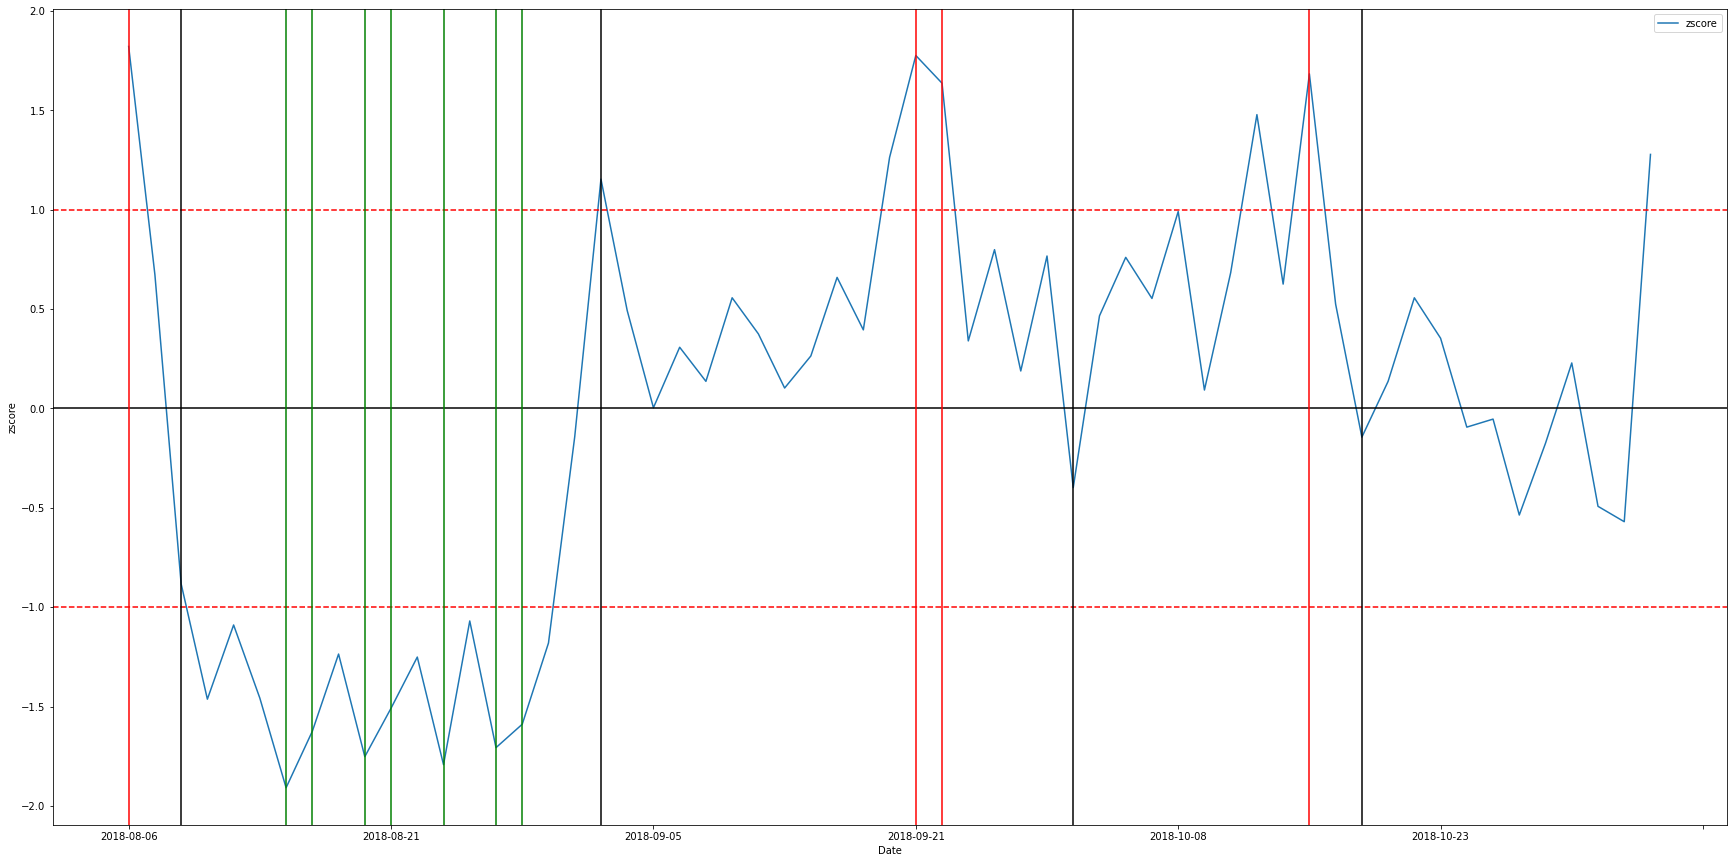

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

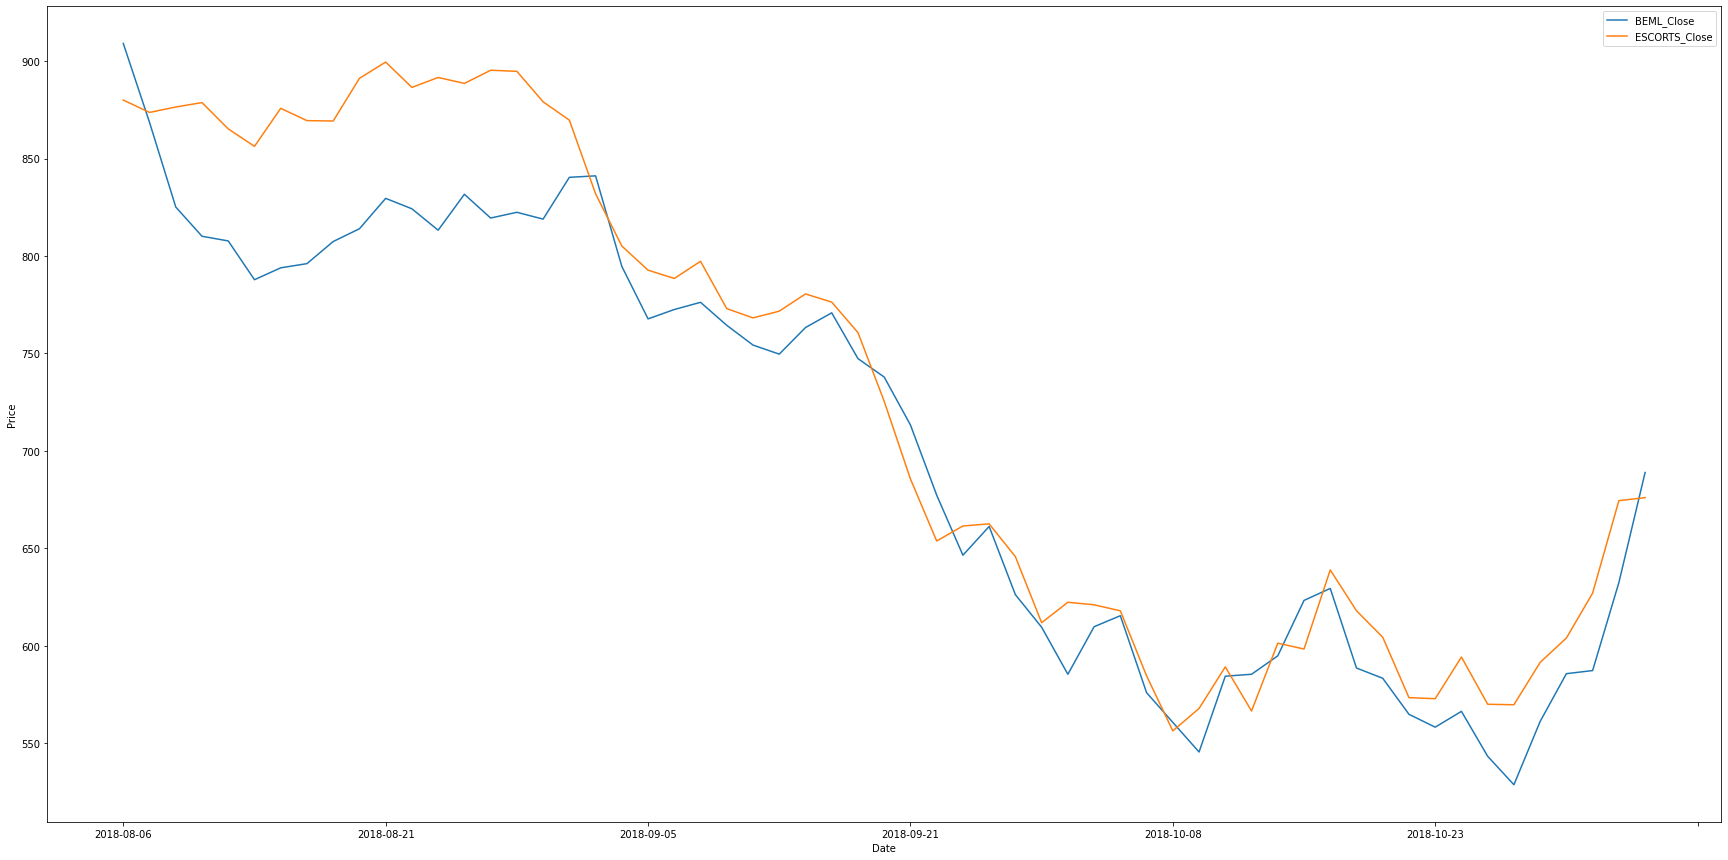

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['BEML_Close', 'ESCORTS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ESCORTS Linear Regression Model

## 3.1. Get the Complete ESCORTS dataset

In [6]:
escorts_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ESCORTSNSE.csv")
escorts_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,324.000000,293.500000,298.950012,320.750000,2996742.0,317.104218,ESCORTS,NSE
1,2017-01-03,329.250000,318.750000,321.500000,326.649994,1859220.0,322.937164,ESCORTS,NSE
2,2017-01-04,329.600006,320.049988,326.700012,321.299988,696439.0,317.647980,ESCORTS,NSE
3,2017-01-05,333.000000,322.700012,322.700012,329.549988,1123767.0,325.804199,ESCORTS,NSE
4,2017-01-06,335.000000,320.000000,331.149994,328.250000,862494.0,324.518982,ESCORTS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ESCORTS training data

### 3.2.1 Get complete escorts dataset

In [7]:
escorts_df = escorts_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
escorts_df.head()

,Date,Close
0,2017-01-02,320.750000
1,2017-01-03,326.649994
2,2017-01-04,321.299988
3,2017-01-05,329.549988
4,2017-01-06,328.250000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
escorts_df_train = escorts_df[escorts_df['Date'] >= '2017-09-03']
escorts_df_train.head()

,Date,Close
166,2017-09-04,645.750000
167,2017-09-05,650.299988
168,2017-09-06,651.250000
169,2017-09-07,657.750000
170,2017-09-08,652.950012


In [9]:
escorts_df_train = escorts_df_train[escorts_df_train['Date'] <= '2018-09-04']
escorts_df_train.tail()

,Date,Close
412,2018-08-29,894.799988
413,2018-08-30,879.150024
414,2018-08-31,869.750000
415,2018-09-03,831.950012
416,2018-09-04,805.150024


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(escorts_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,645.750000,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,650.299988,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,651.250000,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,657.750000,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,652.950012,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,894.799988,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,879.150024,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,869.750000,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,831.950012,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
escorts_train_X = escorts_df_train.copy()

In [12]:
escorts_train_X = escorts_train_X.reset_index(drop=True)
escorts_train_X_plot = escorts_train_X.copy()
escorts_train_X = escorts_train_X.drop(columns=["Elapsed", "Close"])
escorts_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
escorts_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
escorts_train_y = escorts_df[(escorts_df['Date'] >= '2017-09-04') & (escorts_df['Date'] <= '2018-09-04')]['Close']
escorts_train_y

166    645.750000
167    650.299988
168    651.250000
169    657.750000
170    652.950012
          ...    
412    894.799988
413    879.150024
414    869.750000
415    831.950012
416    805.150024
Name: Close, Length: 251, dtype: float64

In [15]:
len(escorts_train_X)

251

In [16]:
len(escorts_train_y)

251

## 3.3. Get ESCORTS Test Data

In [17]:
escorts_test_df = orders_df.copy()
escorts_test_df = escorts_df[(escorts_df['Date'] >= '2018-09-04') & (escorts_df['Date'] <= '2018-12-03')].copy()
escorts_test_df.head()

,Date,Close
416,2018-09-04,805.150024
417,2018-09-05,792.750000
418,2018-09-06,788.500000
419,2018-09-07,797.299988
420,2018-09-10,773.000000


In [18]:
escorts_test_df.tail()

,Date,Close
470,2018-11-27,689.349976
471,2018-11-28,682.000000
472,2018-11-29,694.549988
473,2018-11-30,704.700012
474,2018-12-03,707.150024


In [19]:
add_datepart(escorts_test_df, 'Date')
escorts_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,805.150024,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,792.750000,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,788.500000,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,797.299988,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,773.000000,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
escorts_test_X = escorts_test_df.copy()
escorts_test_X = escorts_test_X.drop(columns=['Close', "Elapsed"])
escorts_test_X.reset_index(drop=True, inplace=True)
escorts_test_X.index += 251
escorts_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
escorts_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
escorts_test_y = escorts_df[(escorts_df['Date'] >= '2018-09-04') & (escorts_df['Date'] <= '2018-12-03')]
escorts_test_y.reset_index(drop=True, inplace=True)
escorts_test_y.index += 251
escorts_test_y = escorts_test_y['Close']

In [23]:
escorts_test_y

251    805.150024
252    792.750000
253    788.500000
254    797.299988
255    773.000000
256    768.250000
257    771.700012
258    780.549988
259    776.349976
260    760.700012
261    725.450012
262    685.599976
263    653.750000
264    661.450012
265    662.549988
266    645.700012
267    611.799988
268    622.299988
269    621.000000
270    617.900024
271    584.549988
272    556.299988
273    567.799988
274    589.150024
275    566.500000
276    601.299988
277    598.299988
278    638.900024
279    617.950012
280    604.349976
281    573.349976
282    572.799988
283    594.200012
284    569.950012
285    569.700012
286    591.450012
287    603.950012
288    627.000000
289    674.450012
290    676.000000
291    677.500000
292    673.400024
293    678.250000
294    664.599976
295    653.549988
296    660.599976
297    656.250000
298    664.900024
299    662.900024
300    672.450012
301    659.650024
302    661.599976
303    661.700012
304    671.700012
305    689.349976
306    682

In [24]:
len(escorts_test_X)

59

In [25]:
len(escorts_test_y)

59

## 3.4 Create and Train ESCORTS Model

In [26]:
model = LinearRegression()
model = model.fit(escorts_train_X, escorts_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(escorts_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,894.957322
252,896.301668
253,897.646014
254,898.990361
255,896.179214
256,897.523561
257,898.867907
258,901.556599
259,898.745453
260,900.089799


In [28]:
predictions_df['test_data'] = escorts_test_y
predictions_df

,predictions,test_data
251,894.957322,805.150024
252,896.301668,792.750000
253,897.646014,788.500000
254,898.990361,797.299988
255,896.179214,773.000000
256,897.523561,768.250000
257,898.867907,771.700012
258,901.556599,780.549988
259,898.745453,776.349976
260,900.089799,760.700012


In [29]:
predictions = predictions_df['predictions']
predictions

251    894.957322
252    896.301668
253    897.646014
254    898.990361
255    896.179214
256    897.523561
257    898.867907
258    901.556599
259    898.745453
260    900.089799
261    901.434146
262    904.122838
263    901.311692
264    902.656038
265    904.000384
266    905.344730
267    906.689077
268    887.214097
269    908.179237
270    909.523583
271    910.867929
272    908.056783
273    909.401129
274    910.745475
275    912.089822
276    913.434168
277    910.623022
278    911.967368
279    913.311714
280    916.000406
281    913.189260
282    914.533606
283    915.877953
284    917.222299
285    918.566645
286    915.755499
287    917.099845
288    946.880073
289    930.770228
290    908.056380
291    905.245234
292    906.589580
293    907.933926
294    910.622619
295    907.811472
296    909.155819
297    910.500165
298    911.844511
299    913.188857
300    910.377711
301    911.722057
302    913.066404
303    914.410750
304    912.943950
305    914.288296
306    915

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(escorts_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(escorts_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(escorts_test_y, predictions)))
print('R2 Score:', metrics.r2_score(escorts_test_y, predictions))

Mean Absolute Error: 247.21142817893997
Mean Squared Error: 66280.512967018
Root Mean Squared Error: 257.45002032825323
R2 Score: -13.734528239591599


## 3.6. Visualize the predicitons vs test data

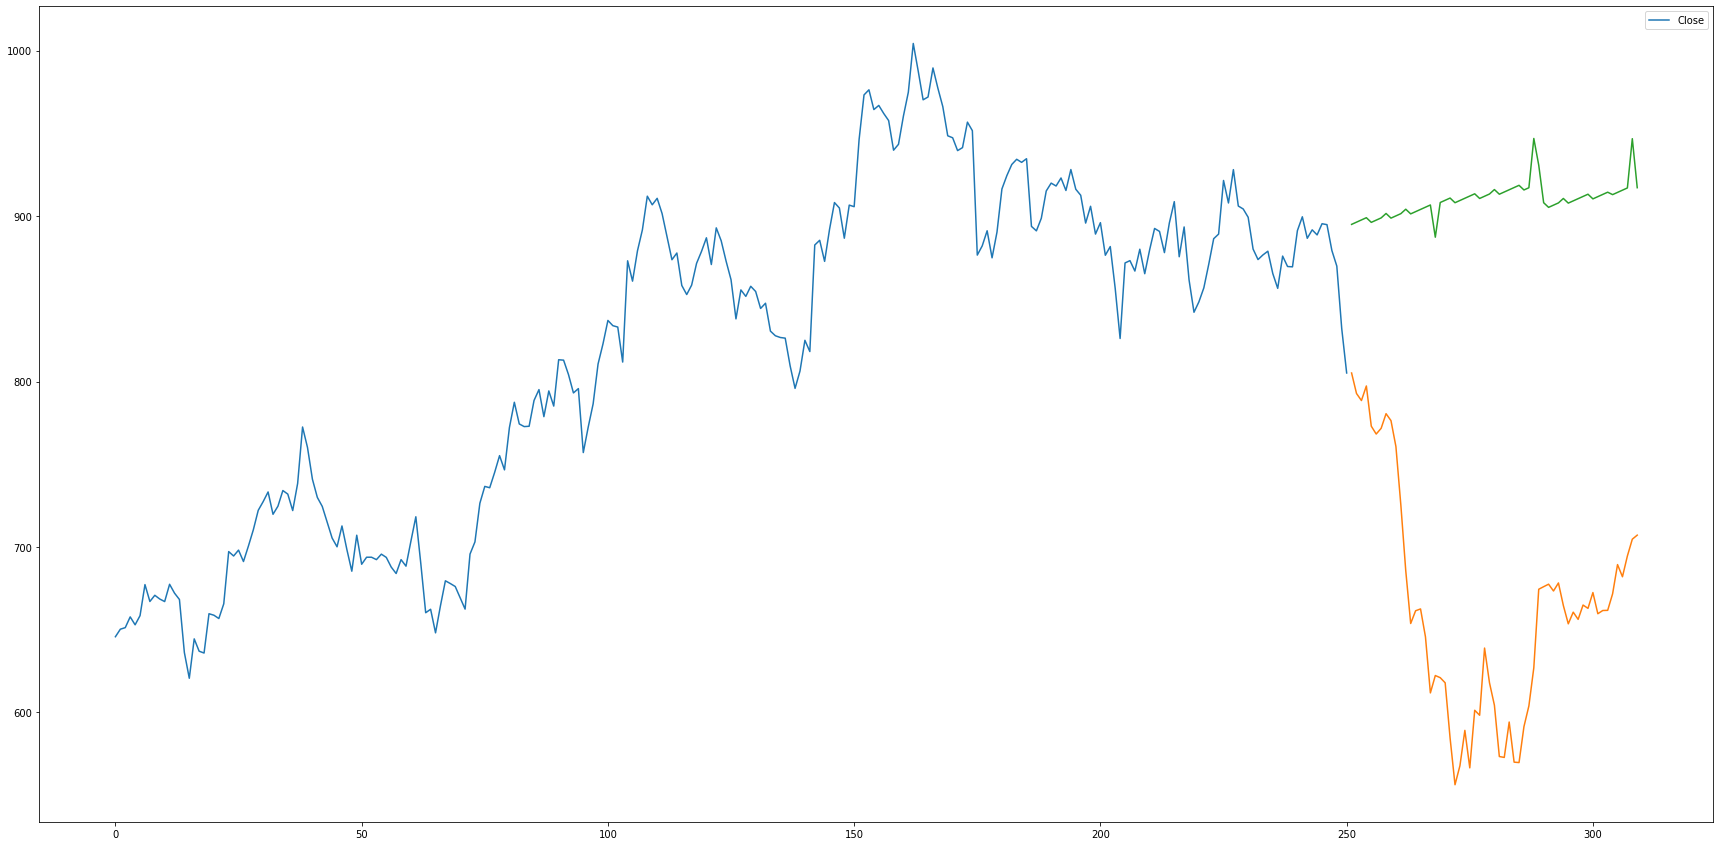

In [31]:
escorts_model_plt = escorts_train_X_plot.plot(y=['Close'], figsize=(30,15))
escorts_model_plt.plot(predictions_df['test_data'])
escorts_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
escorts_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['ESCORTS_Close']}
escorts_predictions_df = pd.DataFrame(escorts_predictions_data)
escorts_predictions_df.head()

,Date,Actual_Close
0,2018-08-06,880.049988
1,2018-08-07,873.700012
2,2018-08-08,876.500000
3,2018-08-09,878.750000
4,2018-08-10,865.250000


In [33]:
predictions_df = predictions_df.reset_index()
escorts_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
escorts_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-08-06,880.049988,894.957322
1,2018-08-07,873.700012,896.301668
2,2018-08-08,876.500000,897.646014
3,2018-08-09,878.750000,898.990361
4,2018-08-10,865.250000,896.179214


In [34]:
escorts_predictions_df.to_csv('Escorts_predicitions.csv', index=False)